# Determining Customer Age

### Project Description
The supermarket chain “Khleb-Sol” is implementing a computer vision system to process photographs of customers. Photo capture at the checkout area will help determine the age of customers to:

Analyze purchases and offer products that may interest customers of that age group.
Monitor the integrity of cashiers when selling alcohol.
Build a model that, based on a photograph, will determine the approximate age of a person. 

## Exploratory Data Analysis (EDA)

In [1]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.duplicated().sum()

0

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


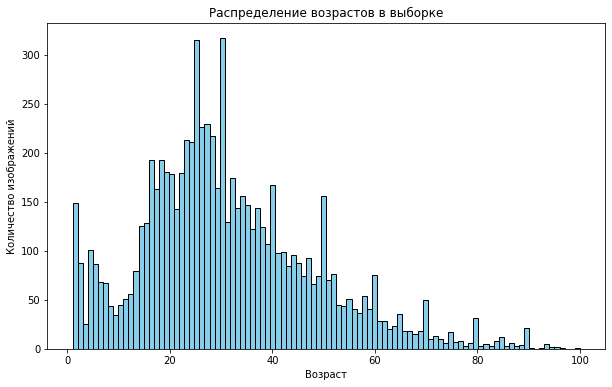

In [6]:
# build the hist
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

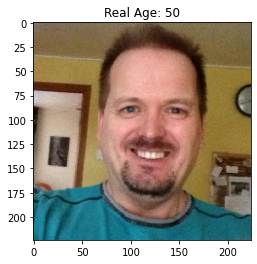

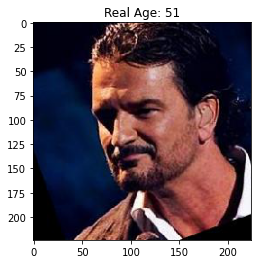

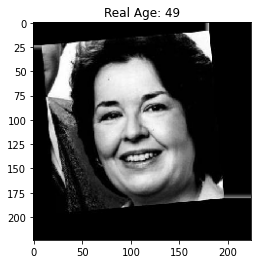

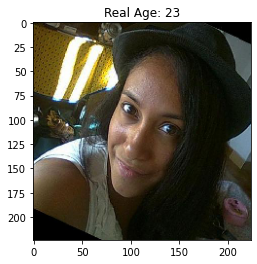

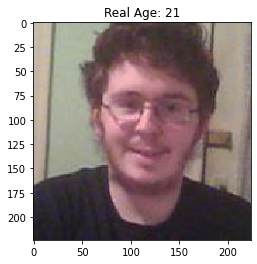

In [7]:
# print the example of the pictures
for i in range(5):
    batch = train_gen_flow.next()
    image = batch[0][0] 
    label = batch[1][0] 
    plt.imshow(image)
    plt.title(f"Real Age: {label}")
    plt.show()

**Conclusion:**

1. Dataset contains 7,591 records of photographs and ages.
2. There are no missing values or obvious duplicates in the data.
3. The age distribution of the individuals in the dataset shows the following characteristics:
* The average age is around 31 years.
* The standard deviation of age is about 17 years, indicating a diverse range of age groups.
* The minimum age in the data is 1 year, and the maximum age is 100 years.
4. The data contains photographs with varying orientations. Most of the photographs are correctly oriented, but there are also some taken at quite an extreme angle.
5. The photographs are of consistent size.
6. The data contains black-and-white photographs, which may impact the model's ability to correctly extract features and generalize information from the images.

## Training the Model

In [8]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255.,
                                       horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            shuffle=False,
            seed=12345) 

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25,
                                            rescale=1/255.)    
    val_datagen_flow = validation_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            shuffle=False,
            seed=12345) 

    return val_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    # замораживаем ResNet50 без верхушки
    # Не замораживаем. Данных достаточно
    #backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(learning_rate=0.0001) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def age_mae(model, val_datagen_flow, validation_steps):

   
    val_datagen_flow.reset()
    real_ages = val_datagen_flow.labels
    
    val_datagen_flow.reset()
    predictions = model.predict(val_datagen_flow, steps=validation_steps) 
    df = pd.DataFrame({'Real_Age': real_ages, 'Prediction': predictions.flatten(),'MAE': abs(real_ages-predictions.flatten())})

    
    grouped_df = df.groupby('Real_Age').agg({'Prediction': ['mean'], 'MAE': ['mean', 'count']})
    grouped_df.columns = ['Mean_Year_Prediction', 'Mean_MAE', 'Image_Count']
    pd.set_option('display.max_rows', None)
    print(grouped_df)


def train_model(model, train_data, test_data, batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    age_mae(model, test_data, validation_steps)
    return model

Train for 178 steps, validate for 60 steps
Epoch 1/50
2023-07-25 13:39:43.368102: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-25 13:39:43.794174: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 84s - loss: 214.6668 - mae: 10.6700 - val_loss: 747.0583 - val_mae: 22.5088
Epoch 2/50
178/178 - 57s - loss: 74.0234 - mae: 6.5661 - val_loss: 726.6651 - val_mae: 22.0906
Epoch 3/50
178/178 - 72s - loss: 47.7914 - mae: 5.2780 - val_loss: 385.8090 - val_mae: 14.9709
Epoch 4/50
178/178 - 69s - loss: 35.6245 - mae: 4.5589 - val_loss: 114.2215 - val_mae: 8.1892
Epoch 5/50
178/178 - 60s - loss: 27.3375 - mae: 4.0181 - val_loss: 85.1543 - val_mae: 6.9181
Epoch 6/50
178/178 - 70s - loss: 21.5287 - mae: 3.4992 - val_loss: 72.5321 - val_mae: 6.4311
Epoch 7/50
178/178 - 64s - loss: 16.4103 - mae: 3.0698 - val_loss: 82.2092 - val_mae: 6.7076
Epoch 8/50
178/178 - 66s - loss: 11.8655 - mae: 2.6131 - val_loss: 65.4251 - val_mae: 6.0099
Epoch 9/50
178/178 - 68s - loss: 10.6272 - mae: 2.4379 - val_loss: 64.8938 - val_mae: 6.0131
Epoch 10/50
178/178 - 40s - loss: 9.3889 - mae: 2.3058 - val_loss: 64.3021 - val_mae: 5.9133
Epoch 11/50
178/178 - 49s - loss: 8.6109 - mae: 2.2120 - val_loss: 62.4169 - val_mae: 5.8838
Epoch 12/50
178/178 - 51s - loss: 7.9940 - mae: 2.1375 - val_loss: 62.0960 - val_mae: 5.9447
Epoch 13/50
178/178 - 40s - loss: 7.3840 - mae: 2.0411 - val_loss: 66.3512 - val_mae: 5.9707
Epoch 14/50
178/178 - 40s - loss: 6.8763 - mae: 1.9763 - val_loss: 64.5046 - val_mae: 5.9763
Epoch 15/50
178/178 - 38s - loss: 6.7041 - mae: 1.9490 - val_loss: 63.7063 - val_mae: 5.8659
Epoch 16/50
178/178 - 38s - loss: 7.3973 - mae: 2.0416 - val_loss: 62.9532 - val_mae: 5.9005
Epoch 17/50
178/178 - 38s - loss: 6.7596 - mae: 1.9748 - val_loss: 66.9854 - val_mae: 6.0517
Epoch 18/50
178/178 - 38s - loss: 6.5591 - mae: 1.9302 - val_loss: 62.5066 - val_mae: 5.7951
Epoch 19/50
178/178 - 38s - loss: 6.4850 - mae: 1.9209 - val_loss: 62.5971 - val_mae: 5.9504
Epoch 20/50
178/178 - 38s - loss: 7.1745 - mae: 2.0336 - val_loss: 62.7134 - val_mae: 5.9495
Epoch 21/50
178/178 - 38s - loss: 7.4886 - mae: 2.0663 - val_loss: 64.0172 - val_mae: 5.9810
Epoch 22/50
178/178 - 46s - loss: 7.8260 - mae: 2.1003 - val_loss: 62.2929 - val_mae: 5.9443
Epoch 23/50
178/178 - 48s - loss: 7.2001 - mae: 2.0470 - val_loss: 71.7846 - val_mae: 6.2042
Epoch 24/50
178/178 - 48s - loss: 7.1370 - mae: 2.0172 - val_loss: 63.2500 - val_mae: 5.8801
Epoch 25/50
178/178 - 48s - loss: 7.5309 - mae: 2.0411 - val_loss: 61.3511 - val_mae: 5.8419
Epoch 26/50
178/178 - 48s - loss: 7.1880 - mae: 2.0167 - val_loss: 59.4536 - val_mae: 5.7236
Epoch 27/50
178/178 - 48s - loss: 12.8160 - mae: 2.6310 - val_loss: 66.0500 - val_mae: 6.0251
Epoch 28/50
178/178 - 48s - loss: 9.0195 - mae: 2.2734 - val_loss: 62.7626 - val_mae: 5.7947
Epoch 29/50
178/178 - 48s - loss: 6.6832 - mae: 1.9589 - val_loss: 59.5339 - val_mae: 5.7303
Epoch 30/50
178/178 - 48s - loss: 5.4704 - mae: 1.7444 - val_loss: 60.5787 - val_mae: 5.7795
Epoch 31/50
178/178 - 48s - loss: 4.8345 - mae: 1.6473 - val_loss: 60.3008 - val_mae: 5.6858
Epoch 32/50
178/178 - 48s - loss: 4.2338 - mae: 1.5365 - val_loss: 60.0028 - val_mae: 5.7498
Epoch 33/50
178/178 - 48s - loss: 3.8542 - mae: 1.4386 - val_loss: 61.6055 - val_mae: 5.7889
Epoch 34/50
178/178 - 48s - loss: 3.7618 - mae: 1.4288 - val_loss: 60.5341 - val_mae: 5.7495
Epoch 35/50
178/178 - 48s - loss: 3.5132 - mae: 1.4052 - val_loss: 63.6597 - val_mae: 5.8309
Epoch 36/50
178/178 - 48s - loss: 3.7198 - mae: 1.4530 - val_loss: 60.2477 - val_mae: 5.6615
Epoch 37/50
178/178 - 40s - loss: 3.8964 - mae: 1.4874 - val_loss: 62.5525 - val_mae: 6.0297
Epoch 38/50
178/178 - 38s - loss: 4.7704 - mae: 1.6517 - val_loss: 61.3947 - val_mae: 5.8081
Epoch 39/50
178/178 - 38s - loss: 4.6356 - mae: 1.6299 - val_loss: 61.4447 - val_mae: 5.7008
Epoch 40/50
178/178 - 38s - loss: 4.8611 - mae: 1.6710 - val_loss: 59.3695 - val_mae: 5.5799
Epoch 41/50
178/178 - 38s - loss: 4.9414 - mae: 1.6742 - val_loss: 62.2902 - val_mae: 5.9319
Epoch 42/50
178/178 - 38s - loss: 5.1041 - mae: 1.6987 - val_loss: 60.3957 - val_mae: 5.7425
Epoch 43/50
178/178 - 38s - loss: 4.8227 - mae: 1.6555 - val_loss: 59.9115 - val_mae: 5.7875
Epoch 44/50
178/178 - 38s - loss: 4.4811 - mae: 1.6078 - val_loss: 58.1902 - val_mae: 5.5464
Epoch 45/50
178/178 - 40s - loss: 4.6462 - mae: 1.6104 - val_loss: 59.8520 - val_mae: 5.5954
Epoch 46/50
178/178 - 40s - loss: 4.7776 - mae: 1.6483 - val_loss: 58.5938 - val_mae: 5.6475
Epoch 47/50
178/178 - 40s - loss: 4.5824 - mae: 1.6058 - val_loss: 67.5340 - val_mae: 6.2643
Epoch 48/50
178/178 - 40s - loss: 4.1951 - mae: 1.5556 - val_loss: 58.6775 - val_mae: 5.6705
Epoch 49/50
178/178 - 41s - loss: 4.0746 - mae: 1.5098 - val_loss: 64.4363 - val_mae: 6.0299
Epoch 50/50
178/178 - 56s - loss: 3.6615 - mae: 1.4336 - val_loss: 58.1618 - val_mae: 5.6335
          Mean_Year_Prediction   Mean_MAE  Image_Count
Real_Age                                              
1                     2.860380   2.343118           45
2                     5.474870   3.818086           24
3                     8.045856   5.045857            9
4                     9.102209   5.444925           30
5                    11.308814   6.557758           29
6                    14.175141   8.770578           20
7                    13.153628   6.153628           22
8                    11.502302   3.839046           13
9                    12.672802   5.911539           11
10                   15.902280   5.902280           12
11                   17.109133   6.860320           14
12                   18.577042   7.814975           13
13                   21.822311   8.878571           22
14                   21.610947   7.611753           36
15                   21.538383   6.565952           35
16                   21.514521   5.883078           44
17                   21.902023   5.051268           52
18                   23.874792   5.899392           50
19                   23.937984   5.214244           47
20                   23.630035   4.547113           45
21                   25.066769   4.591655           31
22                   24.283939   3.338546           47
23                   24.404436   3.534307           62
24                   26.335373   3.909184           55
25                   27.228983   3.855950           88
26                   28.172911   4.264770           60
27                   28.106148   3.900860           61
28                   29.681240   4.461669           51
29                   28.928295   5.136711           37
30                   29.890791   4.383505           88
31                   30.922760   4.715888           26
32                   29.466829   3.775001           34
33                   30.486950   3.635280           29
34                   33.168571   4.876729           38
35                   31.635439   5.536790           40
36                   32.854950   5.256525           27
37                   32.738823   5.426531           29
38                   34.550377   6.126925           23
39                   33.364777   6.422087           19
40                   37.736786   5.941892           51
41                   36.668152   6.930684           22
42                   34.578571   9.340564           22
43                   40.447792   4.613487           18
44                   40.584694   5.402047           26
45                   37.501850   8.020274           22
46                   40.981464   6.109336           11
47                   40.110451   8.653851           19
48                   46.914818   6.373742           18
49                   42.231869   7.629086           18
50                   44.200794   7.724766           46
51                   44.159813   8.056175           13
52                   45.165657   8.088516           15
53                   46.206379   7.145397            9
54                   45.908340   8.981476           12
55                   47.345642   7.668715            9
56                   46.842369   9.157630            6
57                   50.570541   6.808832           12
58                   49.332100   8.667899           10
59                   54.436432   6.113678           11
60                   55.297039   8.321930           26
61                   62.847183   8.369006            4
62                   54.382519   8.342405            3
63                   54.190613   8.809387            4
64                   54.728336  11.503492            3
65                   58.288036   8.162941            9
66                   54.199169  11.800831            2
67                   58.822594   8.474022            4
68                   59.431847  14.602562            2
69                   61.036034   7.963964            4
70                   61.931610   9.195576           12
71                   67.750763   3.249237            1
72                   60.619755  11.380245            2
73                   65.860283   7.139717            2
75                   67.468750   8.337929            7
80                   70.650085   9.473195            9
82                   59.008904  22.991096            1
83                   62.496529  20.503471            1
84                   67.678894  16.321102            2
85                   71.108322  13.891678            2
86                   61.973869  24.026131            1
87                   75.256554  11.743446            1
88                   75.698837  12.301163            1
90                   74.106316  15.893685            6
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 58.1618 - mae: 5.6335
Test MAE: 5.6335

## Model Analysis

1. The dataset contains 7,591 records of people’s photographs and their ages. There are no missing values or obvious duplicates in the data. The average age is around 31 years, and the standard deviation of age is about 17 years, indicating the presence of diverse age groups. The minimum age in the data is 1 year, and the maximum age is 100 years.

2. The model was trained on the data using the ResNet50 architecture, which was fine-tuned for age prediction based on photographs. Training was conducted for 50 epochs using mean squared error as the loss function and mean absolute error (MAE) as the metric. After training, the model showed good performance on the validation set, with an MAE of 5.6335.

3. The most accurate age predictions were achieved for children aged 1 year, with an average absolute error of around 2.34. Good results were also obtained for middle-aged individuals between 20 and 35 years. However, the prediction accuracy drops significantly with age, which could be due to a lack of training data for older age groups, as well as the fact that people in this age range can look significantly different (for example, someone who is 60 or 70 years old may look like they are 50).